# Описание проекта "Определение возраста покупателей"



Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. 
В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
y_df = pd.read_csv('/datasets/faces/labels.csv')#загрузим данные из csv файла

In [ ]:
y_df.head()#посмотрим на общий вид данных в файле labels.csv

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
y_df.shape #проверим размер выборки

(7591, 2)

In [ ]:
y_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Всего 7591 фотография, как и написано в сопроводительной статье к данным.
Средний возраст людей на фотографиях ~31 год, минимальный возраст 1 год, максимальный - 100 лет.
Аномалий в данных нет.

In [ ]:
y_df['real_age'].isnull().sum()

0

Пропущенных значений в данных по возрастам нет.

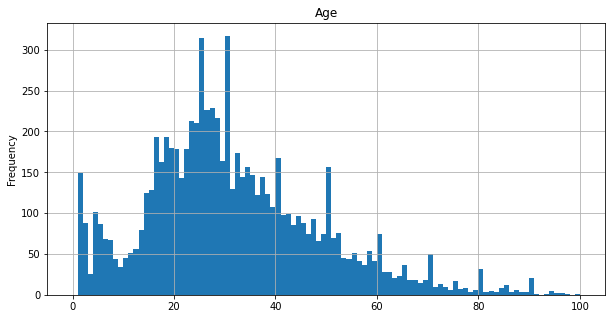

In [ ]:
#Визуализируем распределение возраста в выборке
y_df['real_age'].plot(
                       kind = 'hist', 
                       range = (0,100), 
                       bins=100,
                       title = 'Age',
                       grid=True, 
                       figsize=(10,5)
);

Наибольшее число изображений содержат фотографии людей 18 - 40 лет.

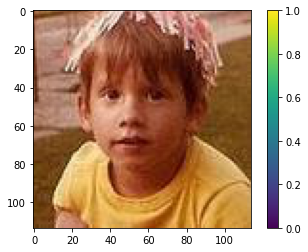

In [ ]:
image = Image.open('/datasets/faces/final_files/000000.jpg') #посмотрим на одну из фотографий в датасете при помощи инструмента Image
array = np.array(image)
array=array/255
plt.imshow(array)
plt.colorbar();

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,) #извлечем данные с признаками и целевыми признаками из папки
train_datagen_flow = datagen.flow_from_dataframe(
dataframe=y_df, 
directory='/datasets/faces/final_files/',
x_col="file_name",
y_col="real_age",
target_size=(150, 150),
batch_size=16,
class_mode='raw')
features, target = next(train_datagen_flow) #разделим признаки 
print(features.shape)
print(target.shape)

Found 7591 validated image filenames.
(16, 150, 150, 3)
(16,)


Получились признаки — четырёхмерный тензор, в котором 16 изображений размером 150x150 с тремя цветовыми каналами.

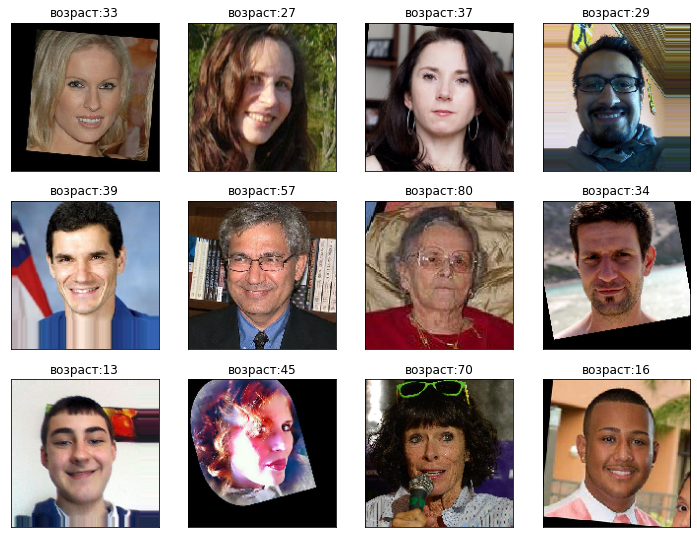

In [ ]:
fig = plt.figure(figsize=(10,10)) #выведем на экран 12 фотграфий
for i in range(12): 
    fig.add_subplot(4,4,i+1)
    plt.imshow(features[i])
    plt.title(f'возраст:{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы по исследовательскому анализу данных**

Выборка содержит не очень большое количество фотографий для качественного определения возраста, причем большая часть фотографий относится к возрастной качегории 20-40 лет, что может говорить о том, что модель будет тяжелее справляться с определением возраста детей и стариков.
Отдельно стоит отметить наличие дополнительных объектов на фотографиях, таких как очки, а также низкое качество фотографий в некотроых случаях, что дополнительно может повлиять на качество модели.

Общая ориентация фотографий примерно одинакова - в некоторых фото их уже повернули за нас, чтобы выровнять положение лица, значит нам их не обязательно поворачивать, а начальный размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). В итоге, размер изображений мы приведем к единому перед обучением модели.

## Обучение модели

Ниже выведем код обучения модели и её результат вывода на экран.

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np  
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense,GlobalAveragePooling2D
optimizer = Adam(lr = 0.0001)
import numpy as np
import pandas as pd

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,)
y_df = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    train_datagen_flow = datagen.flow_from_dataframe(
    dataframe=y_df, 
    directory=path+'final_files/',
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345)
    return train_datagen_flow

def load_test(path):
    val_datagen_flow = datagen.flow_from_dataframe(
    dataframe=y_df, 
    directory=path+'final_files/',
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)
    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                     weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_datagen_flow, 
              validation_data=val_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

```

Train in for 356 steps, validate for 119 steps
Epoch 1/3
2022-09-27 14:21:24.928227: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-27 14:21:25.216217: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 45s - loss: 232.5515 - mae: 11.0108 - val_loss: 655.7995 - val_mae: 20.5953
Epoch 2/3
356/356 - 36s - loss: 72.1151 - mae: 6.5346 - val_loss: 150.7550 - val_mae: 9.1373
Epoch 3/3
356/356 - 36s - loss: 38.1571 - mae: 4.7709 - val_loss: 85.3178 - val_mae: 6.9868
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 85.3178 - mae: 6.9868
Test MAE: 6.9868

```

**Вывод по п.2**

Модель сверточной нейронной сети построена на ResNet50.

Путем снижения значения lr в оптимайзере Adam, MAE на тренировочной выборке удалось уменьшить до 4,8 лет.

## Анализ обученной модели

Обученная модель позволит с относительно высокой точностью предсказывать возраст покупателей.

Средняя абсолютная ошибка может составить не более 7 лет, что является хорошим показателем, т.к. позволяет угадать к какому поколению относится покупатель и выбрать адекватное предложение по товарам, которые могут его заинтересовать.

В то же время, такой разброс в предсказаниях не сможет на должном уровне обеспечить контроль за соблюдением возрастных ограничений при продаже алкоголя, добросовестность кассиров потребуется дополнительно контролировать.